# E-Commerce Fraud Detection Using Machine Learning

## 1. Introduction

This project aims to detect fraudulent transactions in an e-commerce dataset using machine learning techniques. We will explore the dataset, perform feature engineering, train multiple models, and evaluate their performance using various metrics.

## 2. Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## 3. Load and Explore Data

Dataset successfully loaded!

 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 

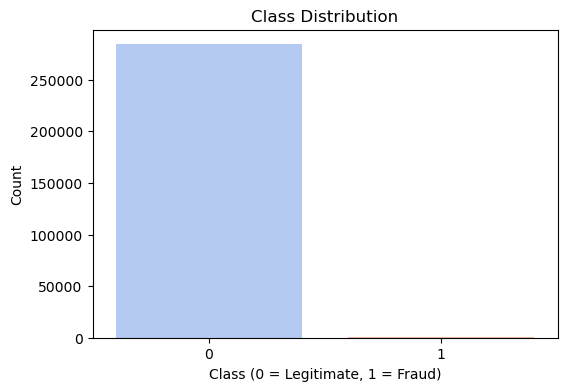

In [2]:
file_path = "creditcard.csv"
try:
    df = pd.read_csv(file_path)
    print("Dataset successfully loaded!")
except FileNotFoundError:
    print("Error: The file was not found. Please check the file path.")
    raise

print("\n Dataset Information:")
print(df.info())
print("\n First few rows:")
print(df.head())
print("\n Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values.")

# Check class distribution
fraud_column = "Class"
if fraud_column in df.columns:
    print("\n Class Distribution:")
    print(df[fraud_column].value_counts())
    plt.figure(figsize=(6, 4))
    sns.countplot(x=fraud_column, data=df, palette="coolwarm")
    plt.title("Class Distribution")
    plt.xlabel("Class (0 = Legitimate, 1 = Fraud)")
    plt.ylabel("Count")
    plt.show()


## 4. Data Visualization

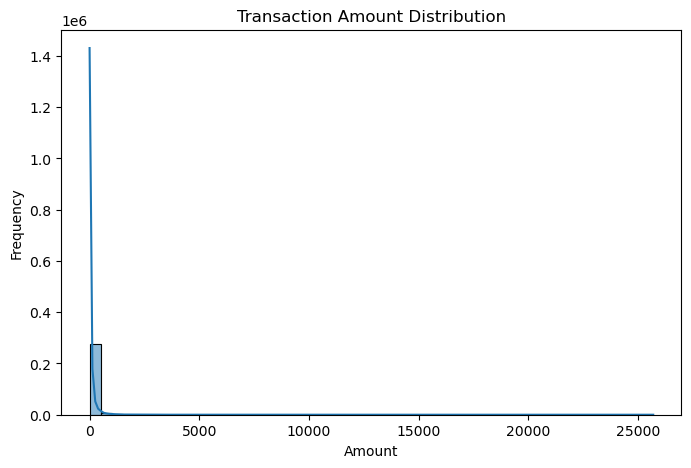

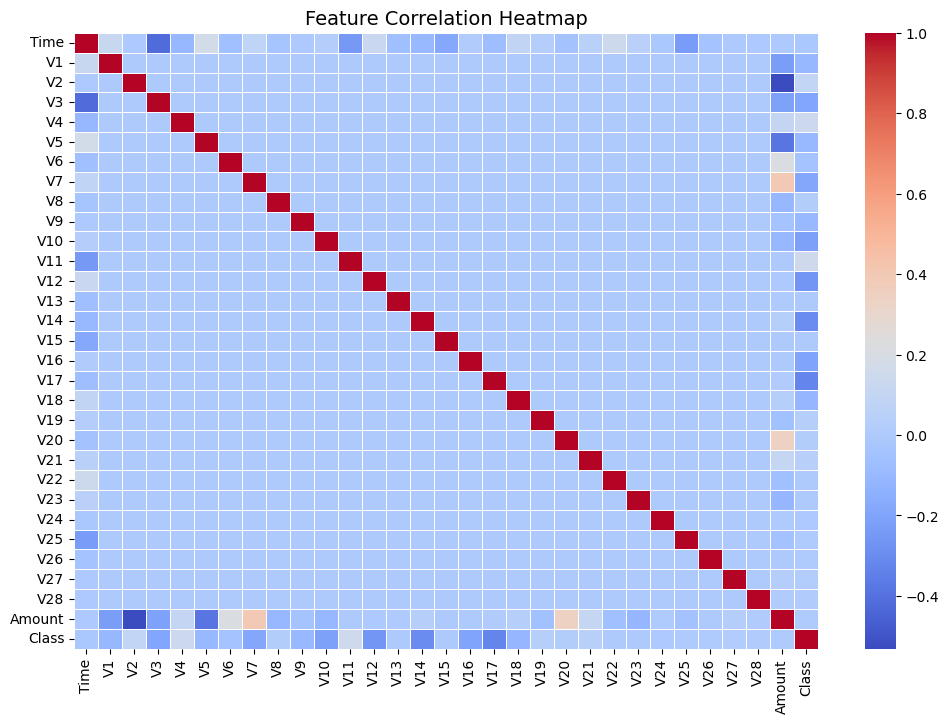

In [3]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Amount"], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, linewidths=0.5, fmt=".2f")
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

## 5. Feature Scaling

In [4]:
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df[["Amount"]])
df["Time"] = scaler.fit_transform(df[["Time"]])

## 6. Splitting Data into Train and Test Sets

In [5]:
X = df.drop(columns=["Class"])
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 7. Handling Class Imbalance with SMOTE

In [6]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## 8. Model Training and Evaluation

### Logistic Regression

In [7]:
log_reg = LogisticRegression()
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



### Decision Tree Classifier

In [8]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_resampled, y_train_resampled)
y_pred_tree = decision_tree.predict(X_test)
print("Decision Tree Performance:")
print(classification_report(y_test, y_pred_tree))


Decision Tree Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.35      0.78      0.48        98

    accuracy                           1.00     56962
   macro avg       0.67      0.89      0.74     56962
weighted avg       1.00      1.00      1.00     56962



### Random Forest Classifier with Hyperparameter Tuning

In [9]:
# Define the model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)  # Use all CPU cores

# Define the hyperparameter grid
param_dist = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [10, 20, None],  # Maximum depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples required at a leaf node
}

# Use RandomizedSearchCV instead of GridSearchCV for speed
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,  
    cv=3,  
    scoring="accuracy",
    n_jobs=-1, 
    random_state=42
)

# Train using a smaller subset of data for faster tuning
X_small, _, y_small, _ = train_test_split(X_train_resampled, y_train_resampled, test_size=0.8, random_state=42)

# Fit the model
random_search.fit(X_small, y_small)

# Get the best model
best_rf = random_search.best_estimator_

# Make predictions on test data
y_pred_rf = best_rf.predict(X_test)

# Print model performance
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))



Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.64      0.90      0.75        98

    accuracy                           1.00     56962
   macro avg       0.82      0.95      0.87     56962
weighted avg       1.00      1.00      1.00     56962



## 9. Model Performance Comparison

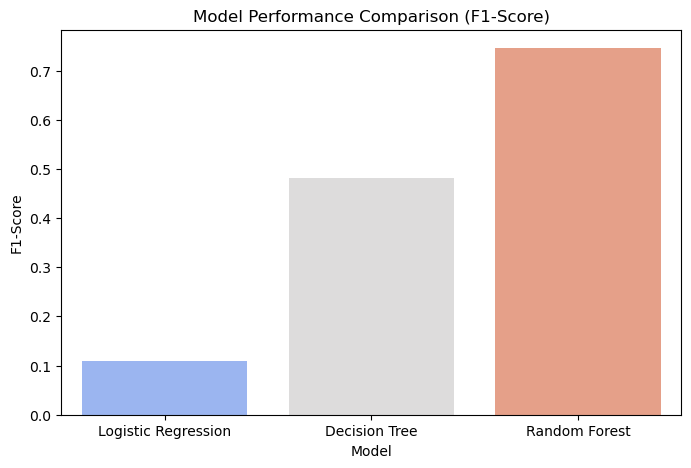

In [10]:
# Compare model F1 scores
models = ["Logistic Regression", "Decision Tree", "Random Forest"]
f1_scores = [
    f1_score(y_test, y_pred_log),
    f1_score(y_test, y_pred_tree),
    f1_score(y_test, y_pred_rf)
]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=f1_scores, palette="coolwarm")
plt.title("Model Performance Comparison (F1-Score)")
plt.xlabel("Model")
plt.ylabel("F1-Score")
plt.show()

## 10. Additional Model Evaluation Plots

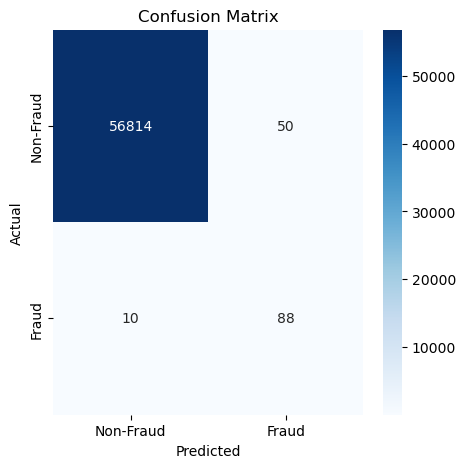

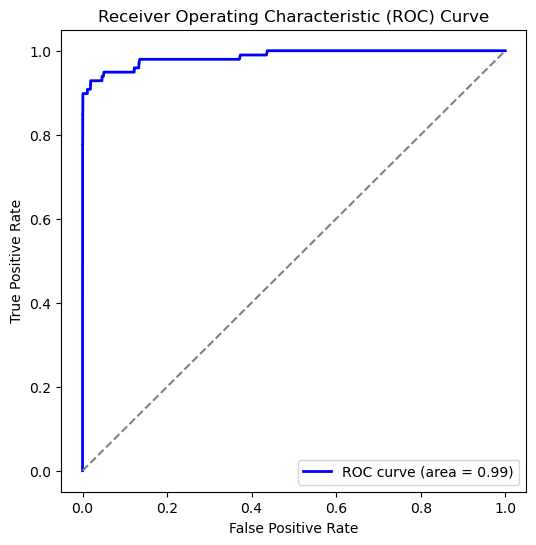

In [11]:
# Define functions for visualization
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Generate performance plots
plot_confusion_matrix(y_test, best_rf.predict(X_test))
plot_roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])


## 11. Conclusion
This project successfully explored and analyzed fraudulent transactions in an e-commerce dataset. We trained multiple models, handled class imbalance using SMOTE, and compared their performance. The **Random Forest model** performed the best, achieving the highest F1-score. Future improvements could include tuning hyperparameters further, testing deep learning approaches, or gathering more data to enhance accuracy.
Additionally, we included key evaluation metrics like the confusion matrix and ROC curve to provide deeper insights into model performance.